In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

In [6]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [7]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Data Load

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 150
batch_size = 16
rescale_factor = 1./255

# Directorio conjunto entrenamiento
data_dir='dataset/Data/train'
test_dir='dataset/Data/test'


# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,    # Normalizar los valores de los píxeles
    shear_range=0.2,   # Rango para las transformaciones aleatorias
    zoom_range=0.2,    # Rango para el zoom aleatorio
    horizontal_flip=True, # Activar el giro horizontal aleatorio
    validation_split=0.2) # Establecer el porcentaje de imágenes para el conjunto de validación

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,      # Directorio con datos
    target_size=(image_size, image_size), # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical', # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

# Cargar imágenes de entrenamiento
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=16,
    class_mode='categorical'
)




Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


## Model

In [9]:
model = Sequential()
# Capas convolucionales

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Dropout(0.2))  # Dropout después de la capa de conv2D
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Dropout(0.2))  # Dropout después de la capa de conv2D
model.add(MaxPooling2D(pool_size=(2, 2)))


# Agregar más capas convolucionales si es necesario

model.add(Flatten())# Aplanar la salida de la capa convolucional
# Aplanar la salida de la capa convolucional
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Usar 'softmax' para clasificación multi-clase

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

2024-01-03 03:15:15.100151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 03:15:15.127998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 03:15:15.128312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Train

In [10]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100

# Entrenar el modelo con Early Stopping
history_of_train = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [early_stopping]
        ,steps_per_epoch=200
)

/tmp/ipykernel_25199/2278667360.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_of_train = model.fit_generator(


Epoch 1/100


2024-01-03 03:15:16.329171: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-03 03:15:16.710605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-01-03 03:15:17.711456: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efea927e850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 03:15:17.711488: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-01-03 03:15:17.717523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704251717.800731   25332 device_compiler.h:186] Compiled cluster using

200/200 [==============================] - 52s 247ms/step - loss: 0.6709 - accuracy: 0.7086 - val_loss: 0.5048 - val_accuracy: 0.8278
Epoch 2/100
200/200 [==============================] - 44s 222ms/step - loss: 0.4278 - accuracy: 0.8225 - val_loss: 0.4256 - val_accuracy: 0.8356
Epoch 3/100
200/200 [==============================] - 44s 222ms/step - loss: 0.4376 - accuracy: 0.8215 - val_loss: 0.4891 - val_accuracy: 0.8414
Epoch 4/100
200/200 [==============================] - 44s 221ms/step - loss: 0.4045 - accuracy: 0.8391 - val_loss: 0.4100 - val_accuracy: 0.8745
Epoch 5/100
200/200 [==============================] - 45s 227ms/step - loss: 0.3990 - accuracy: 0.8425 - val_loss: 0.3800 - val_accuracy: 0.8667
Epoch 6/100
200/200 [==============================] - 46s 231ms/step - loss: 0.3769 - accuracy: 0.8476 - val_loss: 0.3490 - val_accuracy: 0.8891
Epoch 7/100
200/200 [==============================] - 45s 227ms/step - loss: 0.3441 - accuracy: 0.8730 - val_loss: 0.3339 - val_accurac

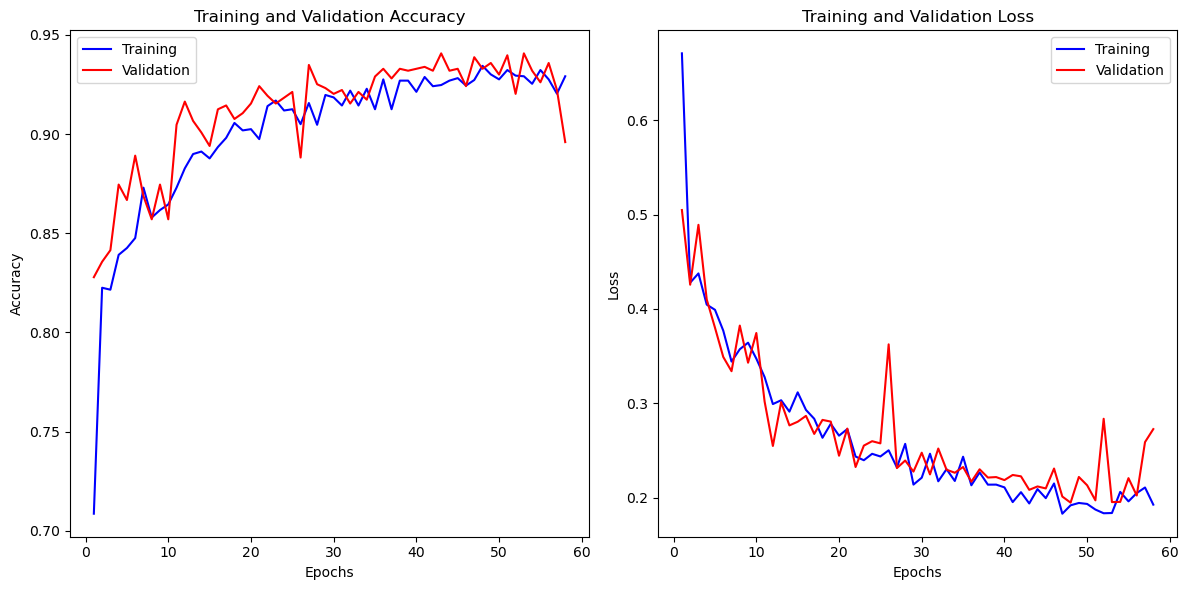

In [12]:
generatePlot(history_of_train)

## Test

In [13]:
# Evaluar el modelo en el conjunto de validación (usado aquí como prueba)
# Puedes limitar el número de pasos para usar solo una parte del conjunto
test_loss, test_accuracy = model.evaluate(test_generator)  # 'steps' es el número de lotes a evaluar

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

81/81 [==============================] - 15s 181ms/step - loss: 0.2529 - accuracy: 0.9123
Test Loss: 0.2528925836086273
Test Accuracy: 0.9122670888900757


In [14]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
model.save("mimodelo7.h5")


# LOADING --------------------------------------------------
model = tensorflow.keras.models.load_model("mimodelo7.h5")

etiquetas = ['Covid19', 'Normal', 'Pneumonia']
cantidad_pruebas = 5  # Número de pruebas que deseas realizar

print("ETIQUETA PREDICHA -> ETIQUETA REAL")
contador_pruebas = 0
for minilote in test_generator:
    if contador_pruebas >= cantidad_pruebas:
        break  # Salir del bucle después de realizar las 50 pruebas
        
    prediccion_minilote = model.predict(minilote[0])
    etiqueta_real_minilote = minilote[1]
    for y_predicha, y_real in zip(np.round(prediccion_minilote, 3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")
    
    contador_pruebas += 1


ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 86ms/step
Pneumonia -> Pneumonia
Pneumonia -> Normal ✘
Covid19 -> Covid19
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Normal ✘
Pneumonia -> Normal ✘
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Covid19 -> Covid19
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
1/1 [==============================] - 0s 17ms/step
Pneumonia -> Normal ✘
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Normal ✘
Normal -> Normal
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Normal -> Normal
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Normal -> Normal
Pneumonia -> Pneumonia
Normal -> Normal
Covid19 -> Covid19
1/1 [==============================] - 0s 18ms/step
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Pneumonia -> Pneumonia
Normal -> Normal
Pneumonia -> Pneumonia
Pneum